In [86]:
!pip install vnstock

In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import stumpy
import matplotlib.pyplot as plt
from datetime import datetime
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from vnstock import * #import all functions

# Read data

Here I want to use stock data of Vietnamses stocks (VNINDEX)

In [88]:
vni_df = stock_historical_data("VNINDEX", "2007-01-01", "2023-10-22", "1D", "index")

In [89]:
vni_df.head()

,time,open,high,low,close,volume,ticker
0,2020-05-11,818.26,828.33,812.48,828.33,353416000,VNINDEX
1,2020-05-13,835.32,839.59,815.13,834.21,374602816,VNINDEX
2,2020-05-15,835.42,838.47,824.59,827.03,301891136,VNINDEX
3,2020-05-18,827.49,827.90,823.23,823.23,29758024,VNINDEX
4,2020-05-19,852.14,854.25,844.15,845.92,385271840,VNINDEX


In [90]:
def create_pct_col(dataframe, pct_cols = []):
    new_df = dataframe.copy()
    for col in pct_cols:
        pct_col_name = f"{col}_pct"  
        new_df[pct_col_name] = new_df[col].pct_change()
        new_df[pct_col_name].replace([np.inf, -np.inf], np.nan, inplace=True)
    return new_df

In [91]:
vni_df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'ticker'], dtype='object')

In [92]:
time_cols = ['time']
float_cols = ['open', 'high', 'low', 'close', 'volume']
cat_cols = ['ticker']

STUMPY uses float datatype as input

In [93]:
def convert_data_type(df, time_cols=[], float_cols = [], cat_cols = []):
    for col in time_cols:
        df[col] = pd.to_datetime(df[col], yearfirst = True)
    for col in float_cols:
        df[col] = df[col].astype(float)
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

In [94]:
vni_df = convert_data_type(vni_df, time_cols, float_cols, cat_cols)

In [95]:
vni_new = create_pct_col(vni_df, pct_cols = ['close', 'volume'])
vni_new.head()

,time,open,high,low,close,volume,ticker,close_pct,volume_pct
0,2020-05-11,818.26,828.33,812.48,828.33,353416000.0,VNINDEX,NaN,NaN
1,2020-05-13,835.32,839.59,815.13,834.21,374602816.0,VNINDEX,0.007099,0.059949
2,2020-05-15,835.42,838.47,824.59,827.03,301891136.0,VNINDEX,-0.008607,-0.194103
3,2020-05-18,827.49,827.90,823.23,823.23,29758024.0,VNINDEX,-0.004595,-0.901428
4,2020-05-19,852.14,854.25,844.15,845.92,385271840.0,VNINDEX,0.027562,11.946822


In [96]:
vni_close = vni_df[['close', 'open']]
vni_close.head()

,close,open
0,828.33,818.26
1,834.21,835.32
2,827.03,835.42
3,823.23,827.49
4,845.92,852.14


In [97]:
def format_date_from_idx(df, start_index:int, m:int):
    '''
    Create start_date and end_date from start index of dataframe and window size
    m: window size
    output: (str): '%Y-%m-%d'
    '''
    start_date_timestamp = df.iloc[start_index]
    end_date_timestamp = df.iloc[start_index + m - 1]

    # Format start date and end date in the same format as input
    formatted_start_date = start_date_timestamp.strftime('%Y-%m-%d')
    formatted_end_date = end_date_timestamp.strftime('%Y-%m-%d')
    return formatted_start_date,formatted_end_date

In [98]:
def find_similar_subseries_with_date(stock_data, 
                           start_date:str = '2023-06-30', end_date:str = '2023-10-15',
                           time_col:str = 'time',
                           price_col:str = 'close'
                          ):
    # Convert the time column to datetime objects
    stock_data[time_col] = pd.to_datetime(stock_data[time_col], yearfirst = True)
    
    # Filter DataFrame based on input dates using pandas
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]
    
    # Extract the subseries you want to find
    subseries_to_find = filtered_data[price_col].values

    # Compute the matrix profile using stumpy for the full time series
    matrix_profile = stumpy.stump(stock_data[price_col], m=len(subseries_to_find))
    
    start_date_index = np.where(stock_data[time_col] == pd.to_datetime(start_date))[0][0]

    # Find the index of the most similar subsequence
    motif_index = matrix_profile[start_date_index, 1]
    print (f'The distance score is {matrix_profile[start_date_index, 0]}')

    # Extract the similar subsequence from the full time series
    similar_subsequence = stock_data[price_col].iloc[motif_index:motif_index + len(subseries_to_find)].values
    
    formatted_start_date,formatted_end_date = format_date_from_idx(df = stock_data[time_col],
                                                                  start_index = motif_index,
                                                                  m = len(subseries_to_find))
    
    # Print the indices of the similar subsequence in the full time series and formatted dates
    print(f'Similar Subsequence from {start_date} to {end_date} (Indices: {formatted_start_date} to {formatted_end_date})')
    return formatted_start_date, formatted_end_date


In [99]:
vni_close = vni_df[['time','close']]
vni_close.head()

,time,close
0,2020-05-11,828.33
1,2020-05-13,834.21
2,2020-05-15,827.03
3,2020-05-18,823.23
4,2020-05-19,845.92


# find_similar_subseries_with_date

In [100]:
# Example usage
start_date = '2023-06-30'
end_date = '2023-10-15'
sim_start_date, sim_end_date = find_similar_subseries_with_date(vni_close, start_date, end_date)

The distance score is 5.992122632149529
Similar Subsequence from 2023-06-30 to 2023-10-15 (Indices: 2022-07-05 to 2022-10-18)


/tmp/ipykernel_32/2975123134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[time_col] = pd.to_datetime(stock_data[time_col], yearfirst = True)


In [101]:
def draw_time_series(stock_data, start_date:str = '2023-06-30', end_date:str = '2023-10-15', 
                    time_col:str = 'time',
                   price_col:str = 'close',
                     title:str = "The original",):    
    # Filter DataFrame based on input dates
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]
    
    # Extract data for plotting
    dates = filtered_data[time_col]
    close_prices = filtered_data[price_col]
    
    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(dates, close_prices, marker='o', linestyle='-', color='b')
    plt.title(f'Time Series from {start_date} to {end_date}')
    plt.xlabel(time_col)
    plt.ylabel(price_col)
    plt.grid(True)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

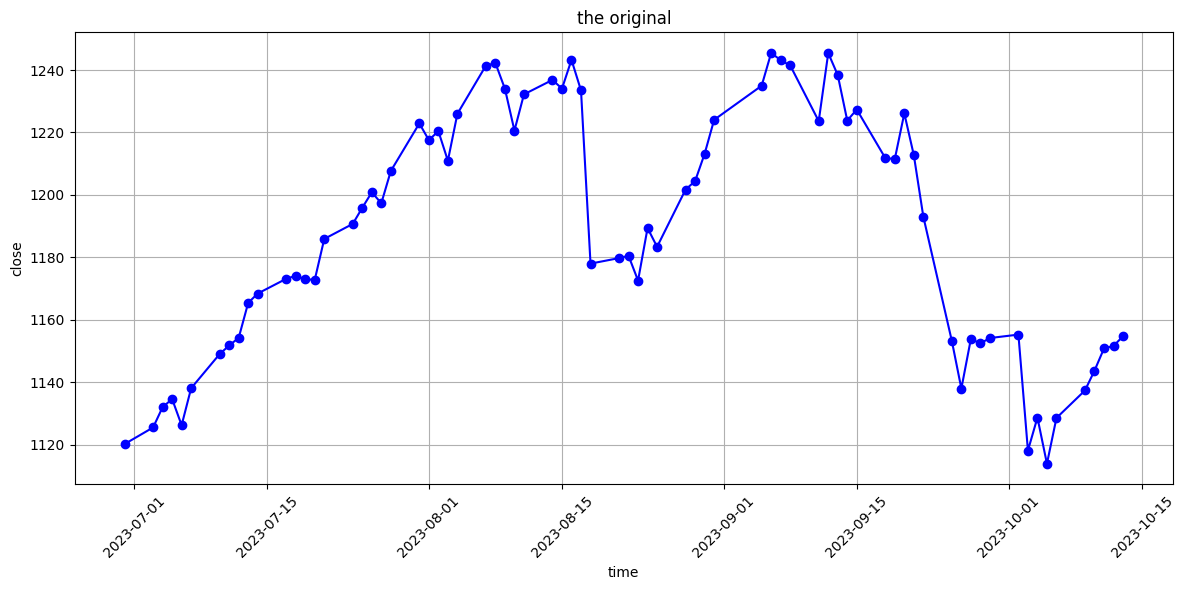

In [102]:
draw_time_series(vni_close, start_date, end_date, title = "the original")

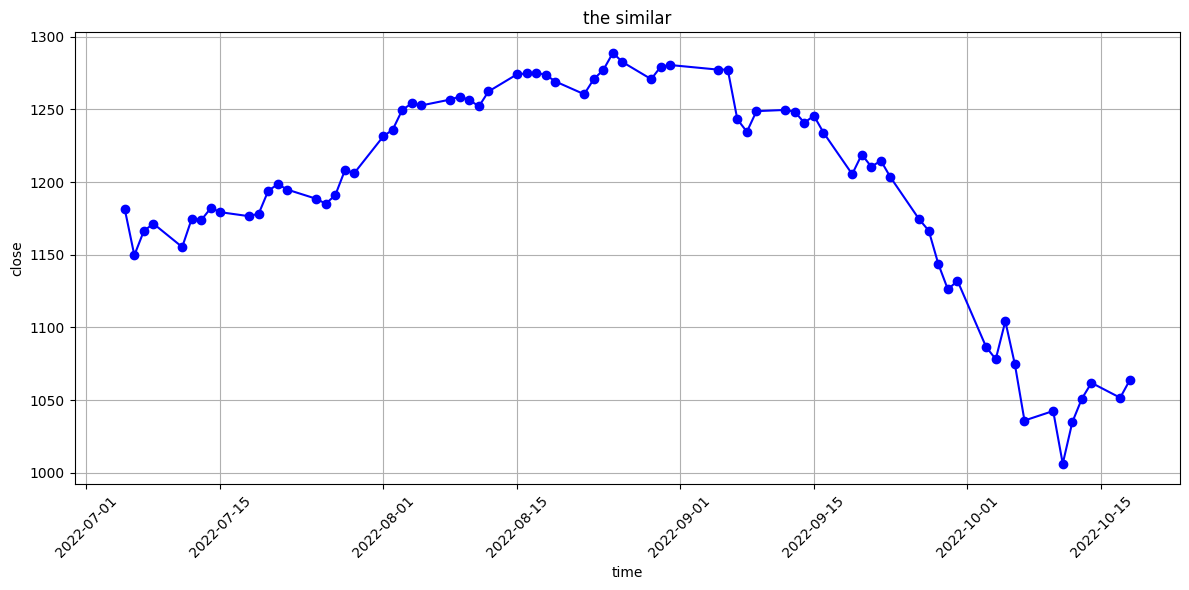

In [103]:
draw_time_series(vni_close, sim_start_date, sim_end_date, title = "the similar")

In [104]:
def find_matching_series_pattern(stock_data, start_date='2023-06-30', end_date='2023-10-15', 
                                 time_col='time', price_col='close', k=3):
    # Filter DataFrame based on input dates
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]  
    Q_df = filtered_data[price_col]
    T_df = stock_data[price_col]
    distance_profile = stumpy.match(Q_df, T_df)
    k_index = distance_profile[:k, 1]
    
    print(f'Top {len(k_index)} similar periods')
    for i, idx in enumerate(k_index):
        formatted_start_date,formatted_end_date = format_date_from_idx(df = stock_data[time_col],
                                                                      start_index = idx,
                                                                      m = len(Q_df))
        distance = distance_profile[i, 0]
        print(f'From {formatted_start_date} to {formatted_end_date}: Distance = {distance}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(T_df.values)
    for idx in k_index:
        plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2, label=f'Series at index {idx}')
    
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# find_matching_series_pattern top periods

Top 4 similar periods
From 2023-06-30 to 2023-10-13: Distance = 4.35073079845778e-06
From 2022-07-05 to 2022-10-18: Distance = 5.992122632150912
From 2022-01-13 to 2022-05-06: Distance = 7.033234485539155
From 2021-04-16 to 2021-08-06: Distance = 7.2641120291108745


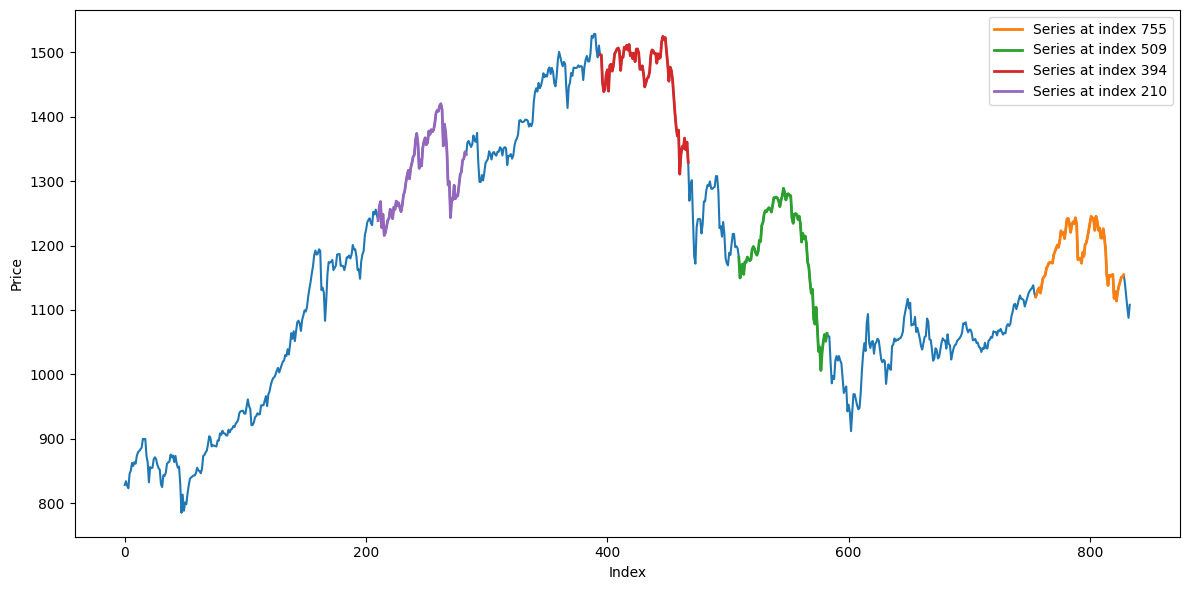

In [105]:
find_matching_series_pattern(vni_close, k=6)

In [106]:
vni_df['volume'] = vni_df['volume'].astype(float)

Top 5 similar periods
From 2023-06-30 to 2023-10-13: Distance = 7.363646686438224e-07
From 2021-10-15 to 2022-01-27: Distance = 8.305352896633815
From 2022-11-01 to 2023-02-20: Distance = 8.722215149331655
From 2022-01-21 to 2022-05-16: Distance = 9.028898237984107
From 2022-09-28 to 2023-01-10: Distance = 9.089728063937045


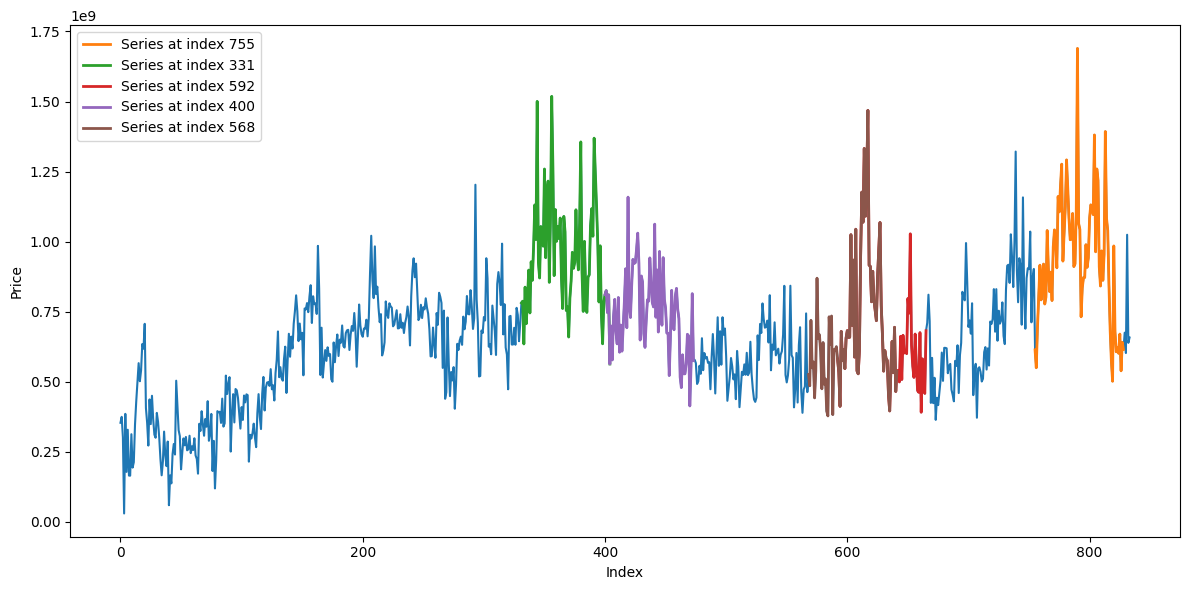

In [107]:
find_matching_series_pattern(vni_df[['time','volume']],price_col ='volume', k=19)

In [108]:
def find_matching_series_multi_dim_with_date (stock_data, 
                                              start_date='2023-06-30', end_date='2023-10-15', 
                                             time_col='time',
                                             dimension_cols = ['close','volume']):
    
    start_date_index = np.where(stock_data[time_col] == pd.to_datetime(start_date))[0][0]
    end_date_index = np.where(stock_data[time_col] == pd.to_datetime(end_date))[0][0]
    m = end_date_index - start_date_index
    df = stock_data[dimension_cols]
    mps, indices = stumpy.mstump(df, m)
    start_date_index = np.repeat(start_date_index, len(df.columns))
    nn_idx = indices[np.arange(len(df.columns)), start_date_index]
    
    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14, 3 * mps.shape[0] * 2))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='20')
        axs[k].plot(df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='20')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

        axs[k].axvline(x=start_date_index[1], linestyle="dashed", c='black')
        axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=start_date_index[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        axs[k].plot(range(start_date_index[k], start_date_index[k] + m), df[dim_name].iloc[start_date_index[k] : start_date_index[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(start_date_index[k], mps[k, start_date_index[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

    plt.tight_layout()
    plt.show()


# find_matching_series_multi_dimension

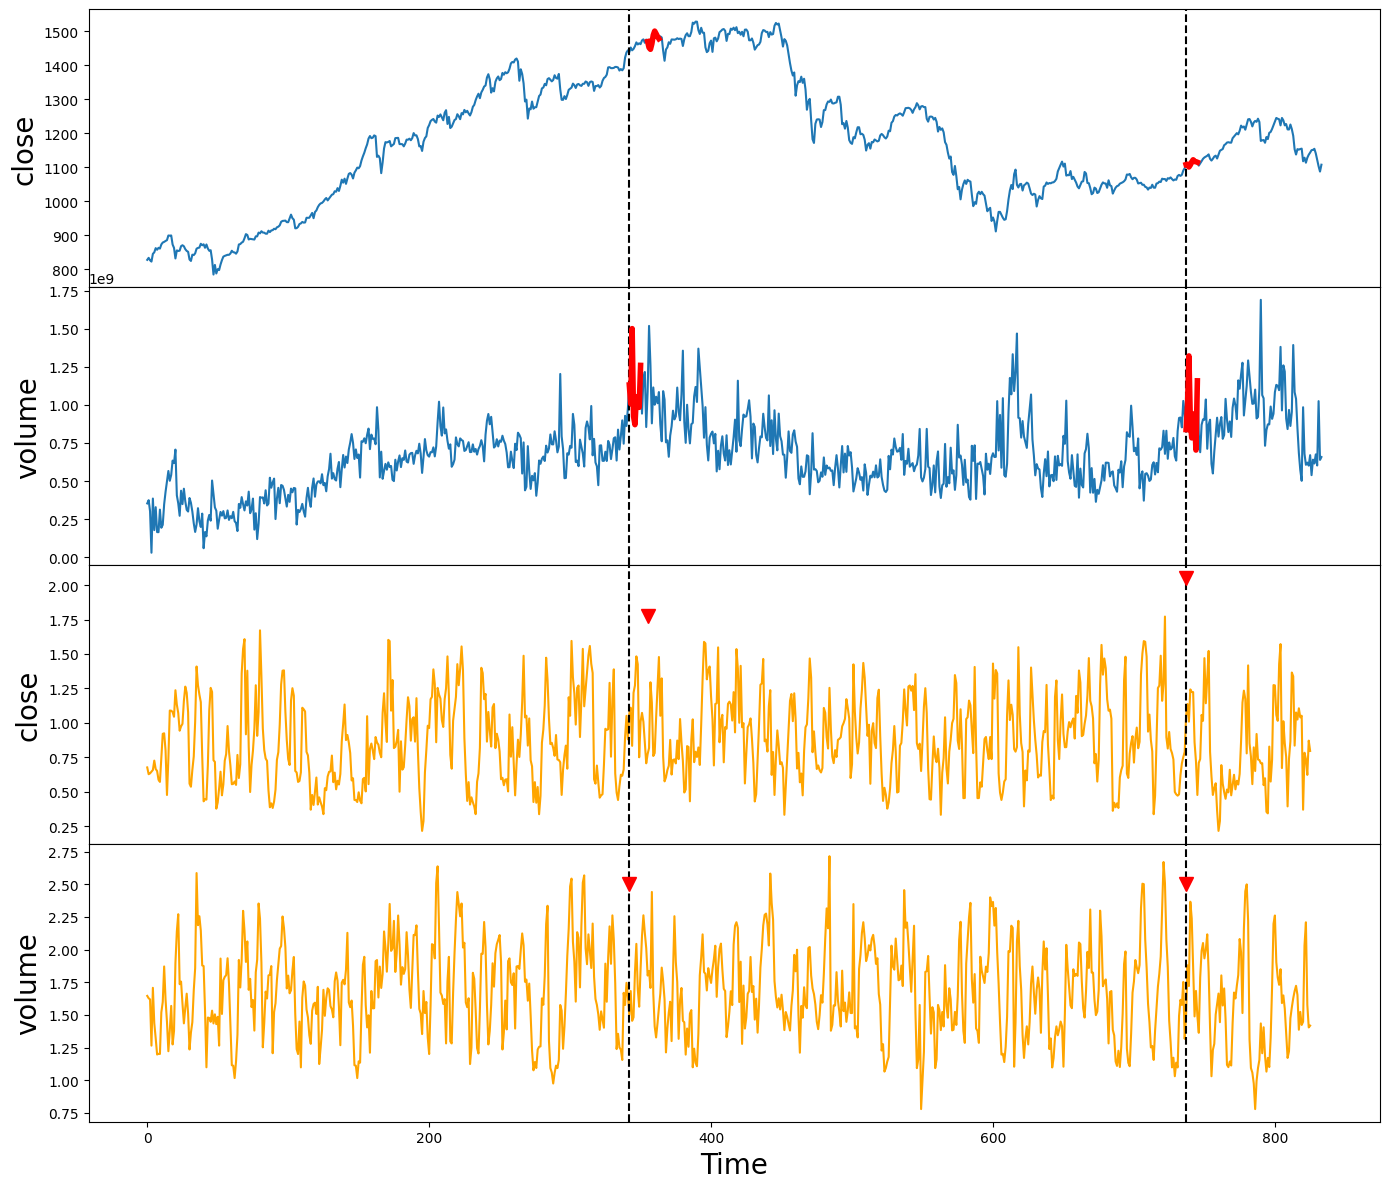

In [109]:
find_matching_series_multi_dim_with_date (vni_df, start_date='2023-06-06', end_date='2023-06-19')

In [110]:
vni_new.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'close_pct',
       'volume_pct'],
      dtype='object')

In [111]:
vni_new

,time,open,high,low,close,volume,ticker,close_pct,volume_pct
0,2020-05-11,818.26,828.33,812.48,828.33,3.534160e+08,VNINDEX,NaN,NaN
1,2020-05-13,835.32,839.59,815.13,834.21,3.746028e+08,VNINDEX,0.007099,0.059949
2,2020-05-15,835.42,838.47,824.59,827.03,3.018911e+08,VNINDEX,-0.008607,-0.194103
3,2020-05-18,827.49,827.90,823.23,823.23,2.975802e+07,VNINDEX,-0.004595,-0.901428
4,2020-05-19,852.14,854.25,844.15,845.92,3.852718e+08,VNINDEX,0.027562,11.946822
...,...,...,...,...,...,...,...,...,...
829,2023-10-16,1154.87,1157.46,1140.64,1141.42,6.748937e+08,VNINDEX,-0.011527,0.097199
830,2023-10-17,1145.34,1147.89,1121.65,1121.65,6.023234e+08,VNINDEX,-0.017321,-0.107528
831,2023-10-18,1123.58,1125.27,1088.87,1103.40,1.024486e+09,VNINDEX,-0.016271,0.700889
832,2023-10-19,1104.03,1104.03,1087.85,1087.85,6.388209e+08,VNINDEX,-0.014093,-0.376447


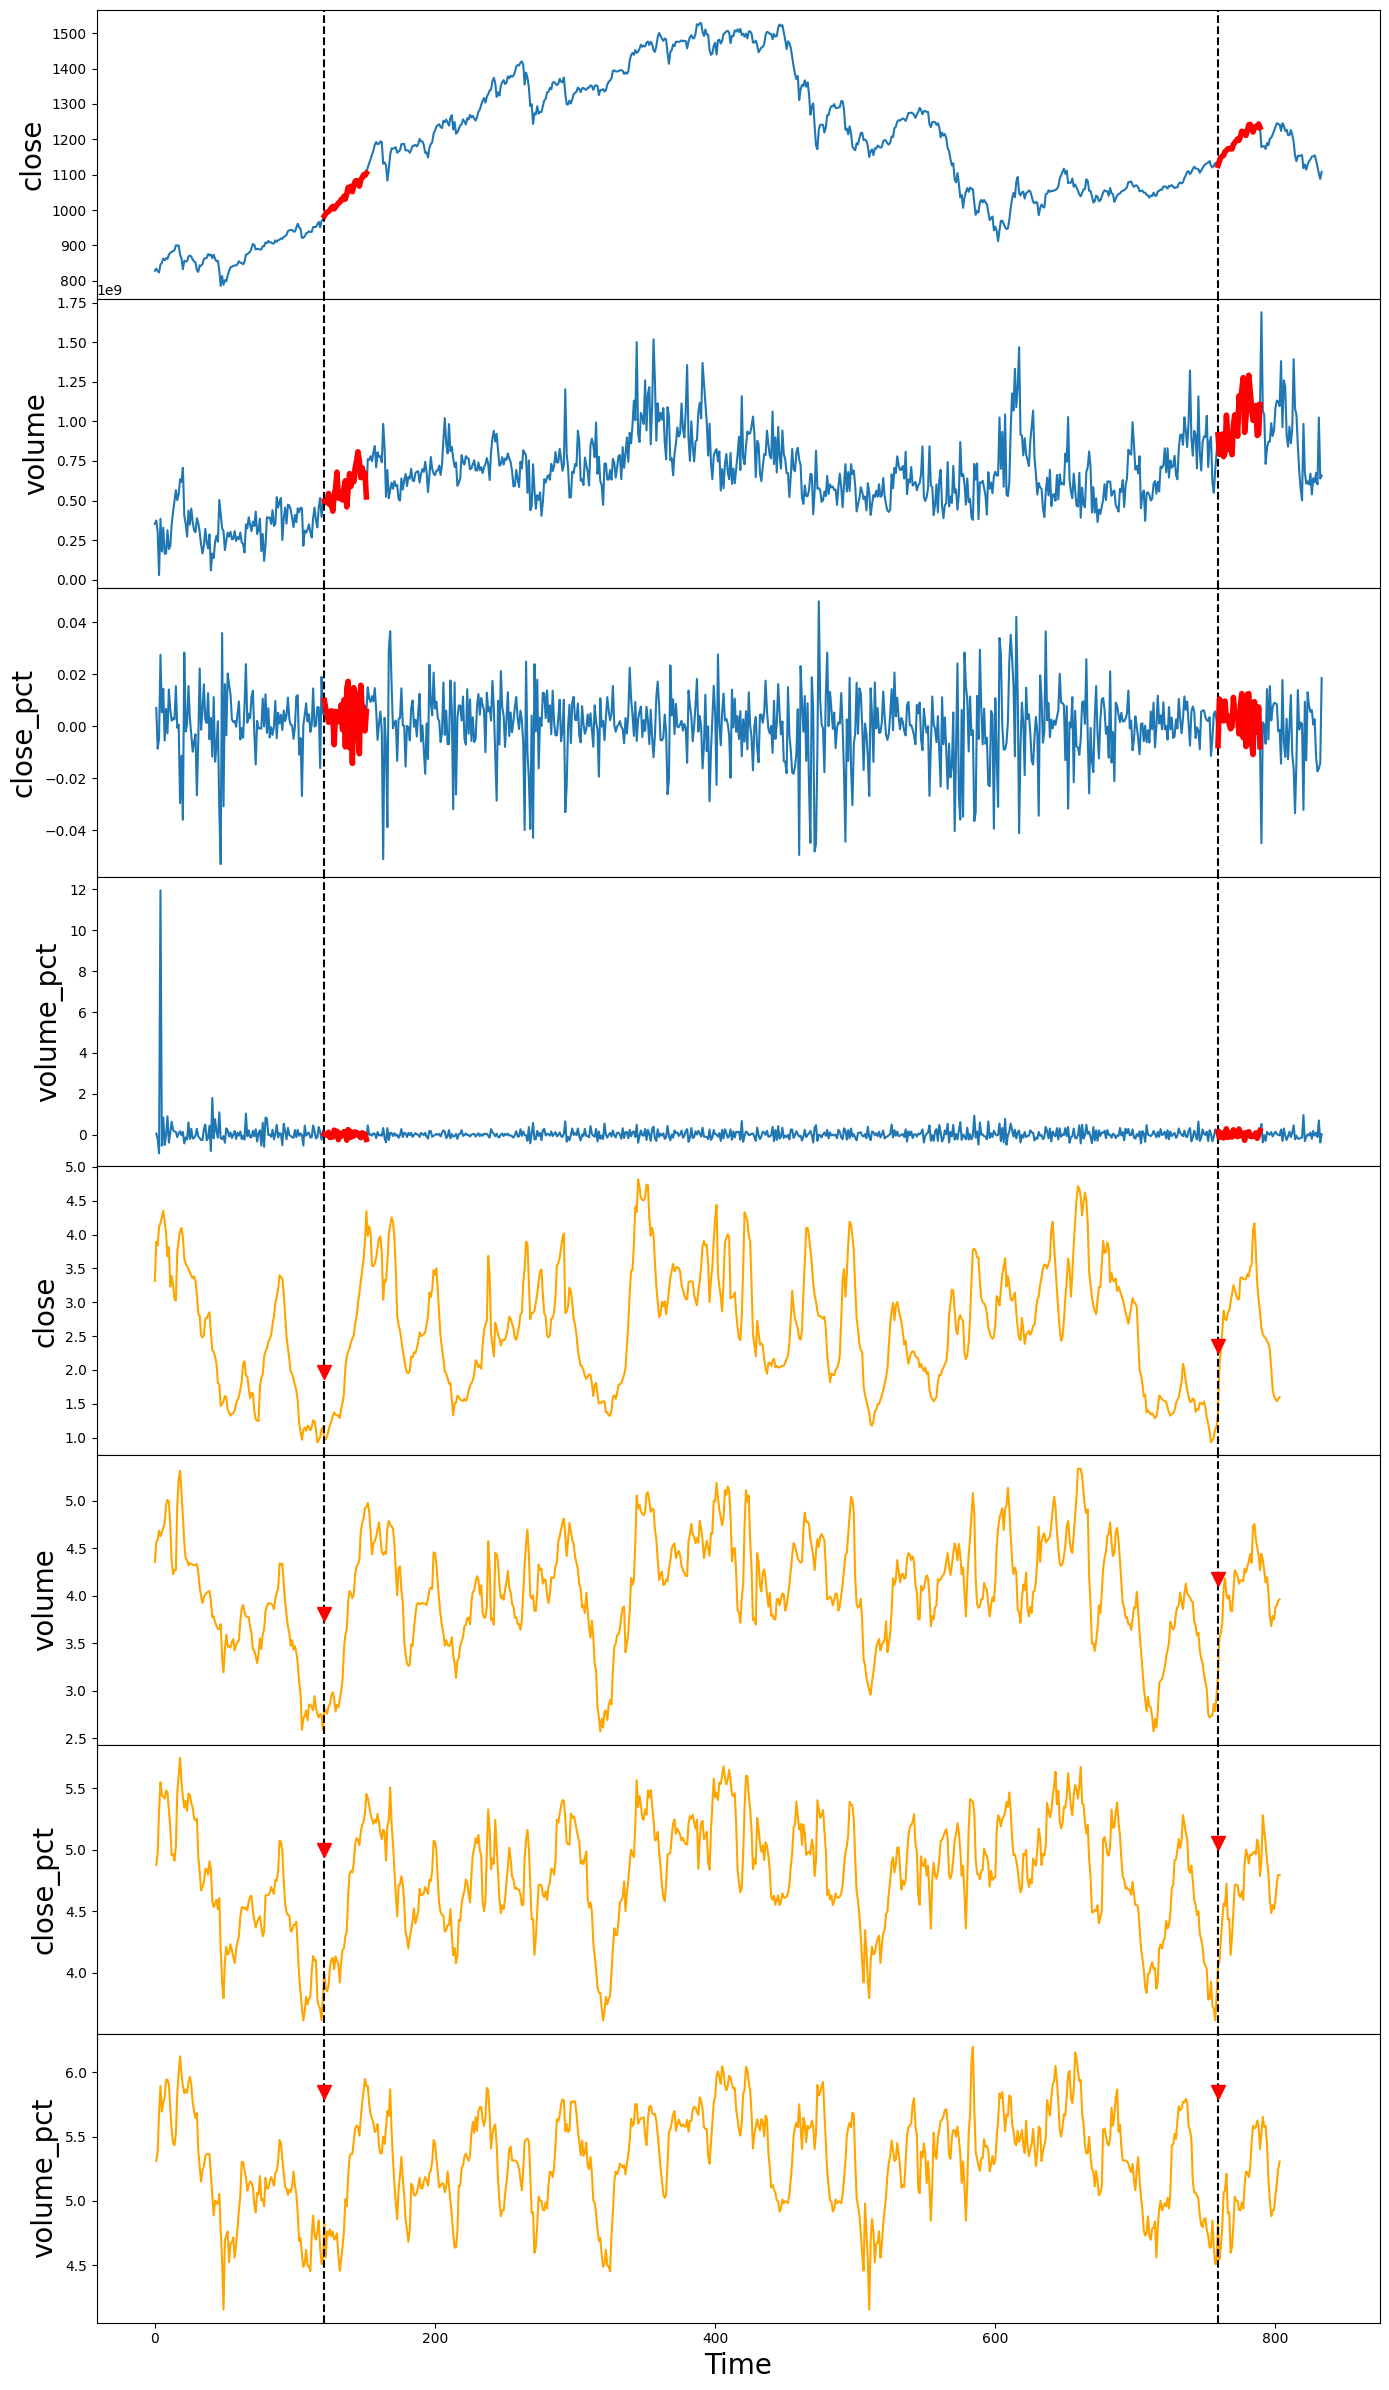

In [112]:
find_matching_series_multi_dim_with_date (vni_new, start_date='2023-07-06', end_date='2023-08-18',
                                         dimension_cols = ['close','volume', 'close_pct','volume_pct'])

In [113]:
def find_matching_series_multi_dim_with_m (stock_data, m:int = 30,
                                             time_col='time',
                                          dimension_cols = ['close','volume']):
    df = stock_data[dimension_cols]
    mps, indices = stumpy.mstump(df, m)
    motifs_idx = np.argmin(mps, axis=1)
    nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14, 3 * mps.shape[0] * 2))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='20')
        axs[k].plot(df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='20')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

        axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

    plt.tight_layout()
    plt.show()


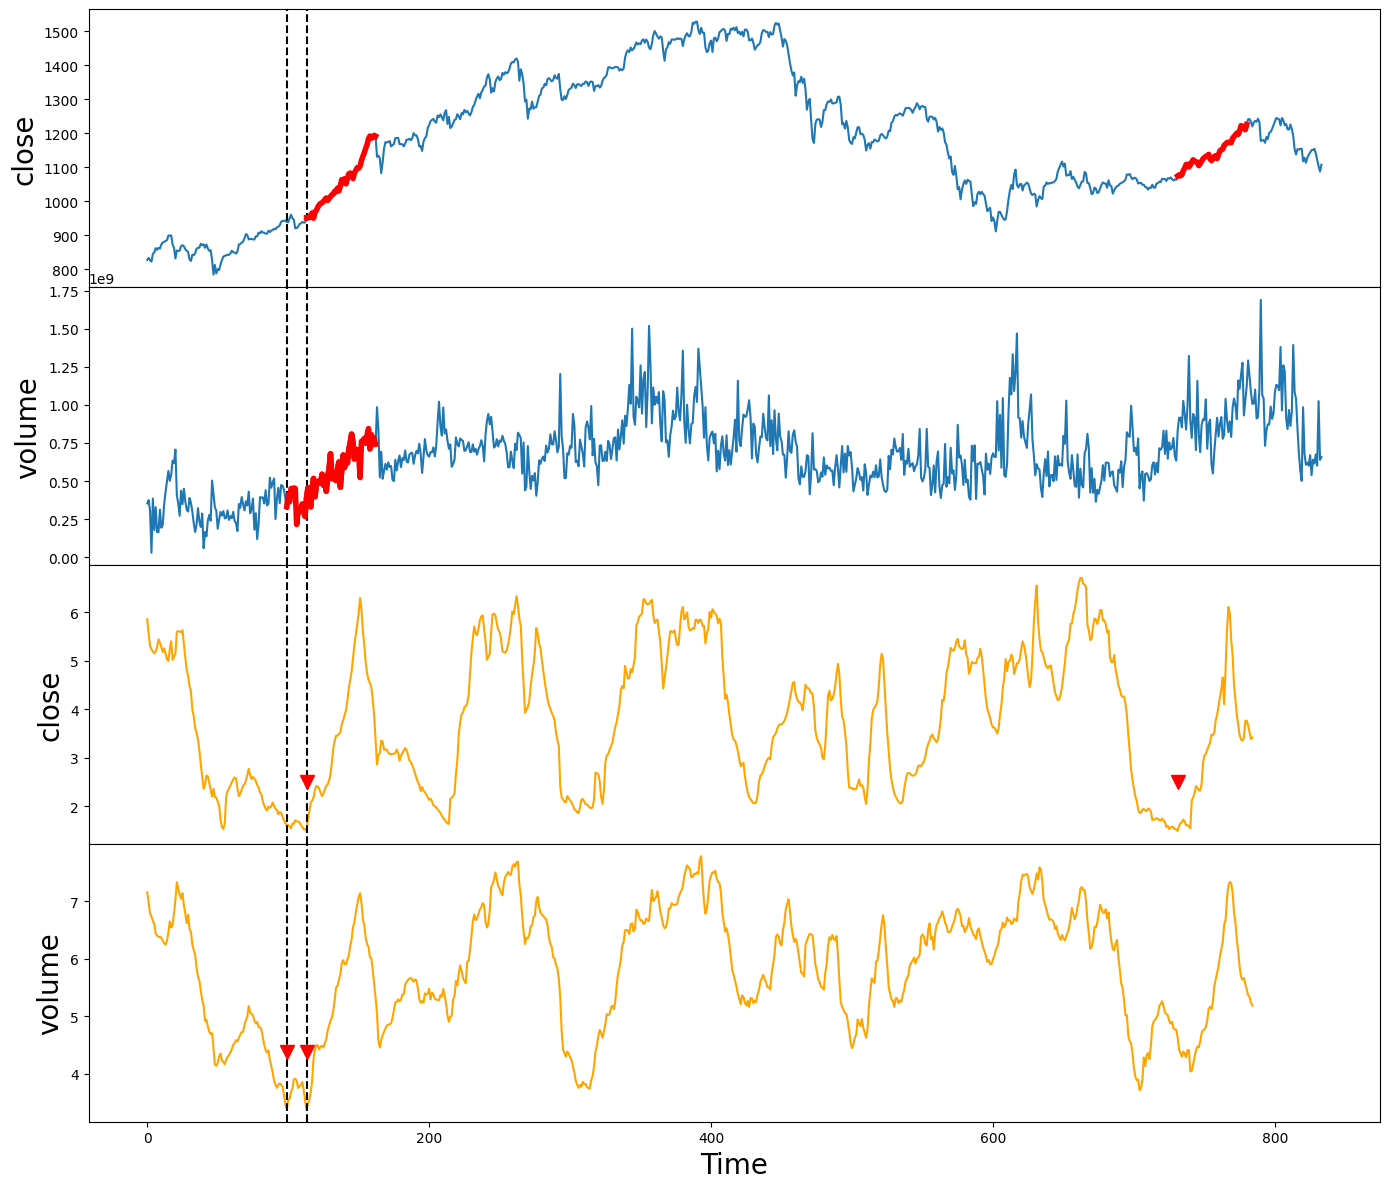

In [114]:
find_matching_series_multi_dim_with_m(vni_df, m = 50,)

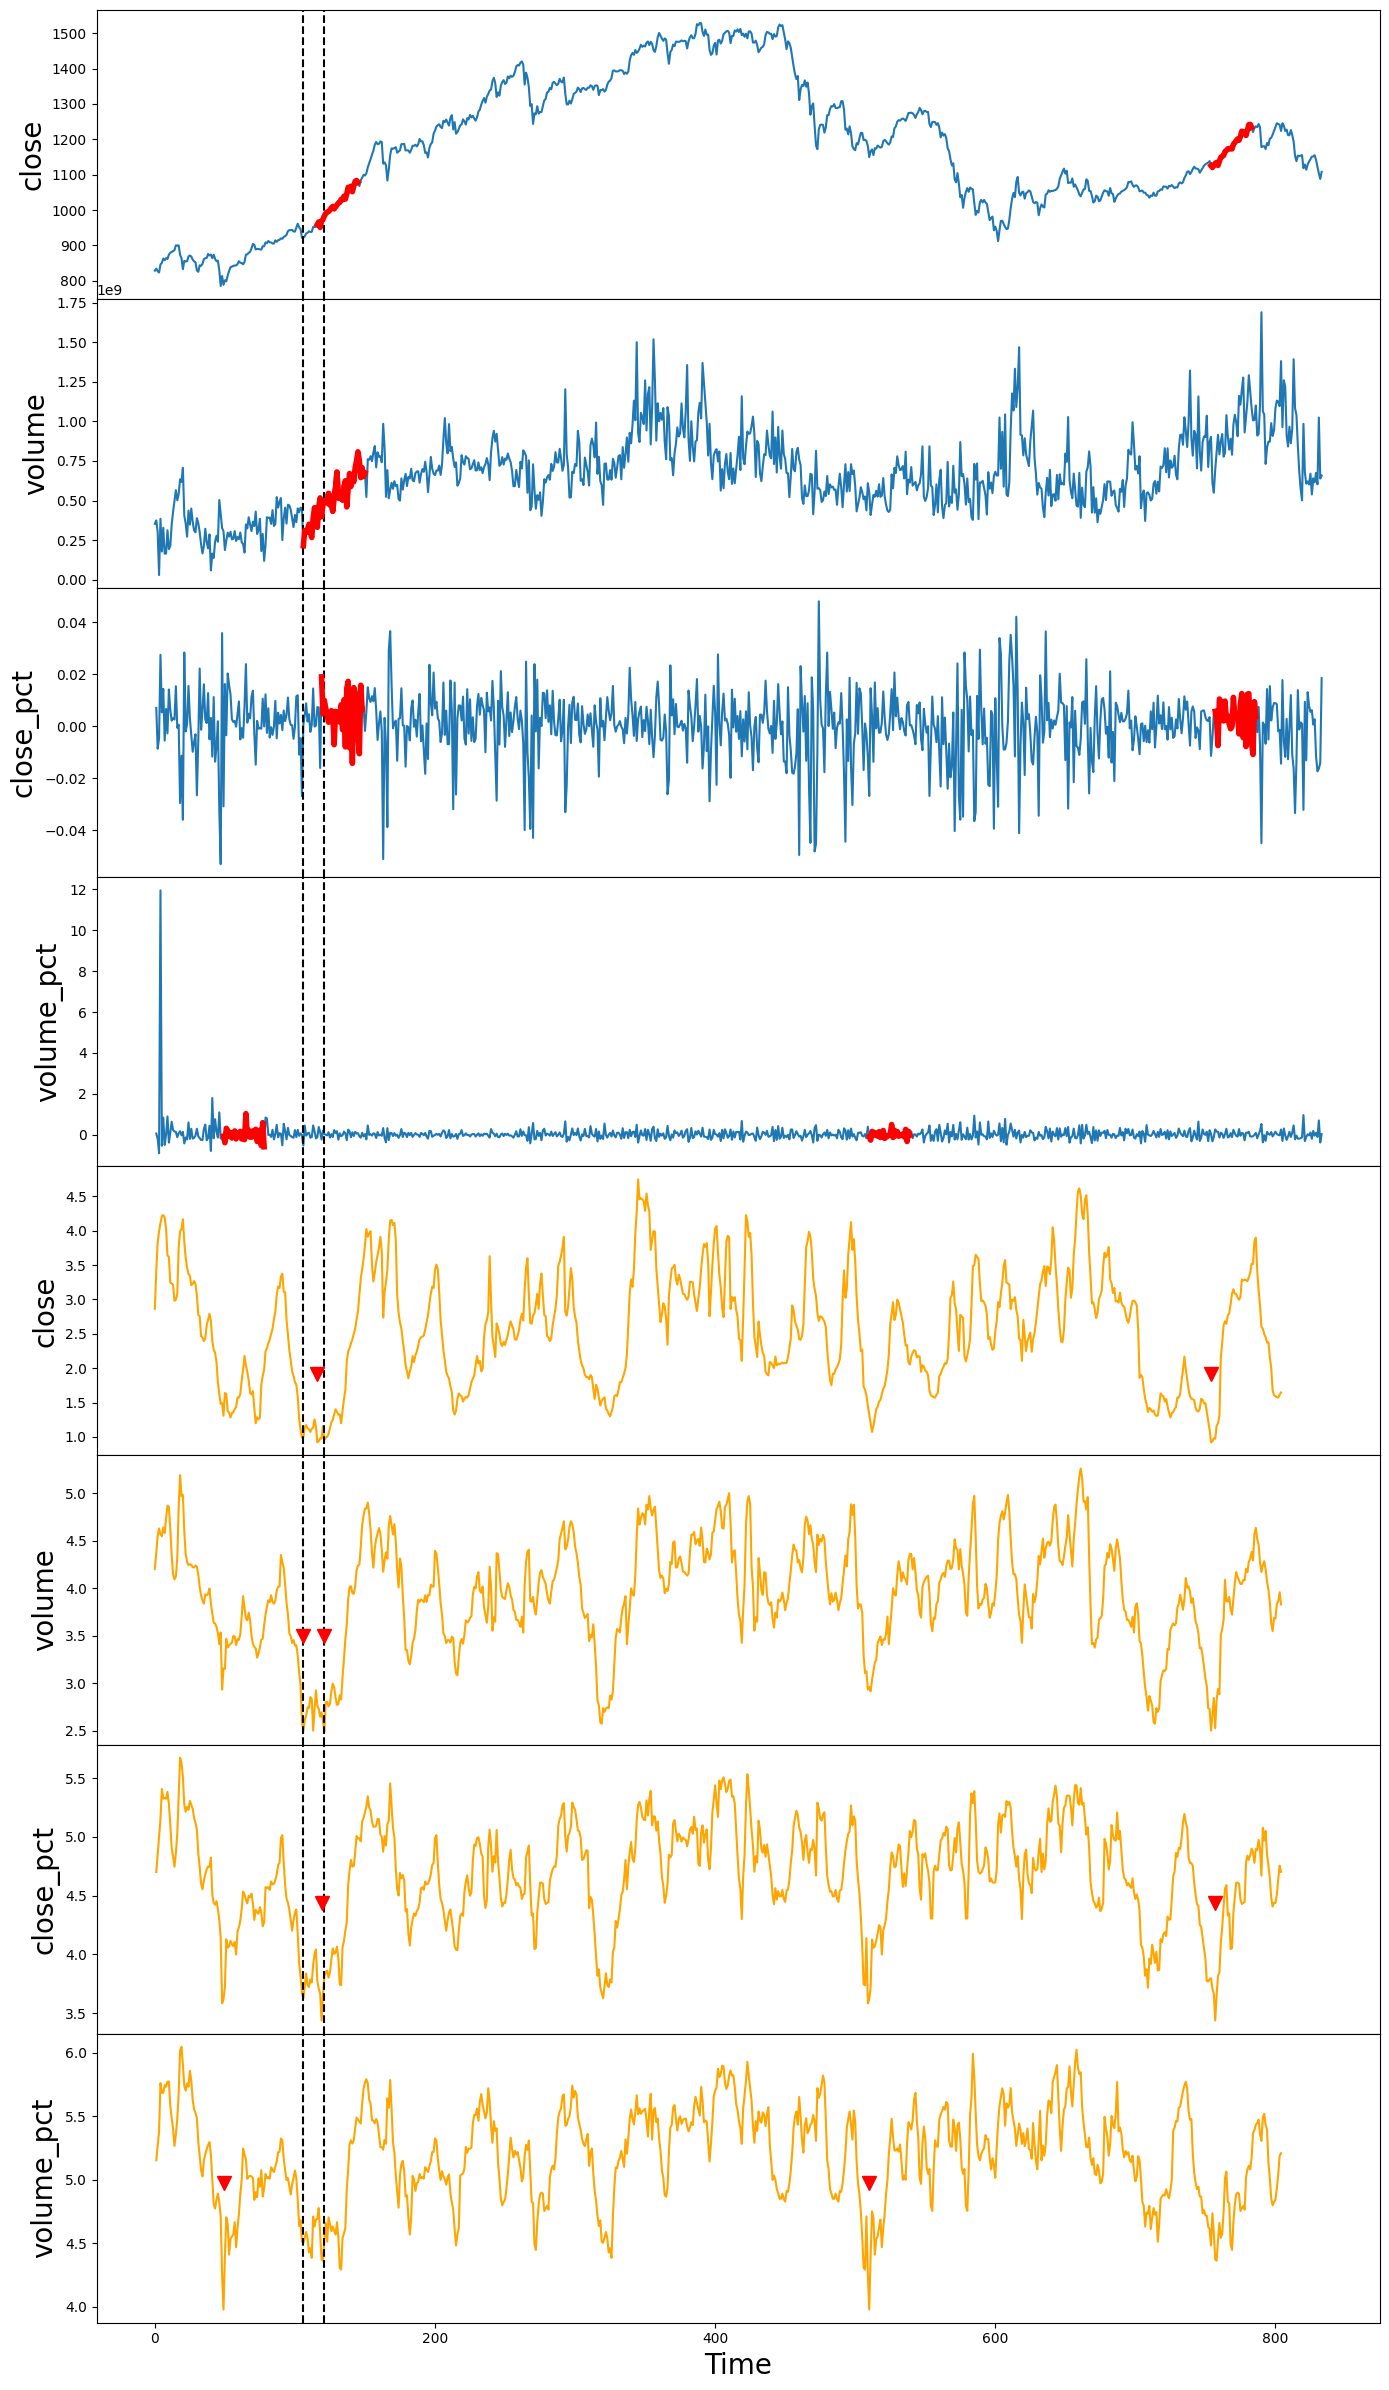

In [115]:
find_matching_series_multi_dim_with_m(vni_new, m = 30,
                                      dimension_cols = ['close','volume', 'close_pct','volume_pct'])